In [1]:
pip install tensorflow_io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 78.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.33.0
    Uninstalling tensorflow-io-gcs-filesystem-0.33.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.33.0


In [2]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import gc
import copy

In [3]:
from tensorflow import keras
from tensorflow import math

In [4]:
import tensorflow as tf
from skimage.color import rgb2lab, lab2rgb
import tensorflow_io as tfio
from tensorflow.keras import datasets, layers, models, Model, utils
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from sklearn.model_selection import train_test_split

In [5]:
#import psutil
#import time


#memory_usage = psutil.virtual_memory()
#print(f"Memory Usage: {memory_usage.percent}%")
#print(memory_usage)


## Load Data

loading on local host

In [6]:
#images_lab = np.load("checkpoint/1001_LAB.npy")
#color_blots = np.load("checkpoint/color_blots.npy")

Loading data in colab

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#del images_train
#del images_train_ab
#del images_test
#del images_test_ab
#gc.collect()

In [9]:
images_lab = np.load("drive/My Drive/deep_learning_projects/LAB/1001_LAB.npy")
color_blots = np.load("drive/My Drive/deep_learning_projects/color_blots/color_blots.npy")

In [10]:
i = 1000

In [11]:
images_lab = images_lab[i-1000:i,:,:,:]
color_blots = color_blots[i-1000:i,:,:,:]

In [12]:
full = np.concatenate([images_lab,color_blots], axis = 3)

In [13]:
del images_lab, color_blots
gc.collect()

75

In [14]:
full.shape

(1000, 512, 256, 6)

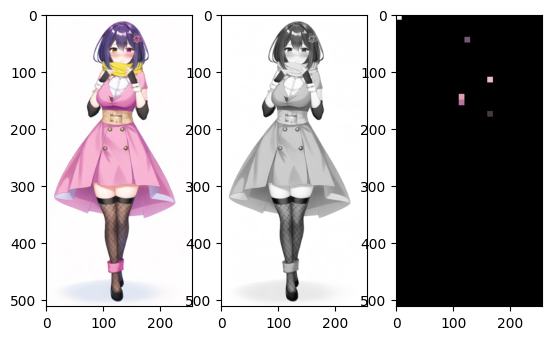

In [15]:
image_idx = 42
fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
img = lab2rgb(full[image_idx,:,:,0:3])
ax1.imshow(img)
ax2.imshow(full[image_idx,:,:,0],cmap = "gray")
ax3.imshow(full[image_idx,:,:,3:6].astype(np.uint8))

## testing values for data normalisation vs standardisation.

In [16]:
#data = copy.deepcopy(full[:,:,:,3:6]/np.max(full[:,:,:,3:6]))
#print(np.max(data))
#print(np.min(data))
#print(np.mean(data))

# Normalisation

In [17]:
full = full.astype(np.float16)

In [18]:
full[:,:,:,0] = full[:,:,:,0]/100
full[:,:,:,1:3] = full[:,:,:,1:3]/127
full[:,:,:,3:6] = full[:,:,:,3:6]/127

In [19]:
#using half of data ...train 700-1400 next round and for test 1700-1850
images_train = full[0:700,:,:,(0,3,4,5)]
images_train_ab = full[0:700,:,:,1:3]
images_test = full[850:1000,:,:,(0,3,4,5)]
images_test_ab = full[850:1000,:,:,1:3]


In [20]:
#images_val_ab = full[i-300:i-150,:,:,1:3]
#images_val = full[i-300:i-150,:,:,(0,3,4,5)]

In [21]:
print(images_train.shape)
print(images_train_ab.shape)
print(images_test.shape)
print(images_test_ab.shape)
#print(images_val.shape)
#print(images_val_ab.shape)

(700, 512, 256, 4)
(700, 512, 256, 2)
(150, 512, 256, 4)
(150, 512, 256, 2)


In [22]:
#import random
#Generate 5 random numbers between 10 and 30
#randomlist = random.sample(range(0, 700), 15)

In [23]:
#1. Loading 1400-1700
#2. Loading 2700-2850
#random_data = np.load("drive/My Drive/deep_learning_projects/random_data/val_images.npy")
#random_data = np.concatenate([random_data,full[randomlist,:,:,:]],axis = 0)
#np.save("drive/My Drive/deep_learning_projects/random_data/val_images.npy",random_data)

In [24]:
#old_val = np.load("drive/My Drive/deep_learning_projects/test_data/val_images.npy")
#old_val_ab = np.load("drive/My Drive/deep_learning_projects/test_data/val_images_ab.npy")
#np.save("drive/My Drive/deep_learning_projects/test_data/val_images.npy",np.concatenate([old_val,images_val],axis = 0))
#np.save("drive/My Drive/deep_learning_projects/test_data/val_images_ab.npy",np.concatenate([old_val_ab,images_val_ab],axis = 0))

In [25]:
#print(images_train[1,:,:,:])

In [26]:
del full#, images_val, images_val_ab
gc.collect()

40

## Defining Unet architecture

In [27]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.4, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning.
    Dropout can be added for regularization to prevent overfitting.
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    #removing batch normalisation as it adds randomness to the data (since the max color of images across batches is not consistent)
    #Normalisation
    #conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (4,4))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection

In [28]:
def process_blot(input):
    # choosing to add blot-layer @ -1 layer as it provides necessary granularity @128*64 pixel
    pool1 = tf.keras.layers.MaxPooling2D(pool_size = (4,4), strides =(4,4))(input)
    #pool1 = tf.keras.layers.MaxPooling2D(pool_size = (4,4))(pool1)
    return pool1

### Testing maxpool block - before normalisation

test = process_blot(images_train[3:4,:,:,1:4].astype(int))
print(test.shape)
plt.imshow(test[0,:,:,:])

## Decoder Block

In [29]:
def DecoderMiniBlock(n_filters, prev_layer_input, skip_layer_input, blot = None, is_blot = False):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(4,4),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    if is_blot:
        blot  = process_blot(blot)
        merge = concatenate([up, skip_layer_input, blot], axis=3)
    else:
        merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [30]:
# Compiling the whole model

In [31]:
def UNetCompiled(input_size=(512, 256, 4), n_filters=32, n_classes=2):
   """
   Combine both encoder and decoder blocks according to the U-Net research paper
   Return the model as output
   """
    # Input size represent the size of 1 image (the size used for pre-processing)
   full_input = Input(input_size)
   inputs, blot_input_size = tf.split(full_input, [1,3], 3)

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
    # choosing 3 blocks that move with stride 4 as anime images tend to have less detail
    # the above decision also helps decrease computation load

   cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
   cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
   cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
   cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=False)
   #cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

   #pool1 = tf.keras.layers.MaxPooling2D(pool_size = (4,4), strides =(4,4))(input)
    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
   #ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)


   ublock5 = DecoderMiniBlock(n_filters * 4, cblock4[0], cblock3[1])
   ublock6 = DecoderMiniBlock(n_filters * 2, ublock5, cblock2[1], blot_input_size, True)
   ublock7 = DecoderMiniBlock(n_filters, ublock6, cblock1[1])

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size.
    # Observe the number of channels will be equal to number of output classes
   conv9 = Conv2D(n_filters/2,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock7)

   conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
   model = tf.keras.Model(inputs=full_input, outputs=conv10)

   return model

## Compiling Model

In [32]:
unet = UNetCompiled(input_size=(512,256,4), n_filters=64, n_classes=2)
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 256, 4)]        0         []                            
                                                                                                  
 tf.split (TFOpLambda)       [(None, 512, 256, 1),        0         ['input_1[0][0]']             
                              (None, 512, 256, 3)]                                                
                                                                                                  
 conv2d (Conv2D)             (None, 512, 256, 64)         640       ['tf.split[0][0]']            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 256, 64)         36928     ['conv2d[0][0]']          

## Running the inital batch of learning

### Custom Loss Funciton

In [39]:
@tf.keras.utils.register_keras_serializable()
@keras.saving.register_keras_serializable()
class Custom_Loss(tf.keras.losses.Loss):
    def __init__(self, reduction=tf.keras.losses.Reduction.AUTO, name=None):
        super().__init__(reduction=reduction, name=name)
    def call(self, y_true, y_pred):
      coeff = 10 # will be converted to x/1000
      y, idx = tf.raw_ops.UniqueV2(x = tf.reshape(tf.math.floor(y_pred), (-1,2)), axis = [0])
      count_pred = tf.size(y)
      count_pred = tf.cast(count_pred, tf.float16)/1000
      count_pred =  coeff * count_pred
      mae = tf.math.reduce_mean(tf.math.abs(tf.math.subtract(y_true, y_pred)))
      mae = tf.cast(mae, tf.float16)
      loss = mae + count_pred
      return loss

### Compiling the model

In [41]:
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.002),
             loss= Custom_Loss() , metrics= 'mae')  # ['mae', Custom_Loss_Metric])

In [42]:
cp_callback = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_loss',
                                                min_delta=0.001,
                                                patience=4,
                                                verbose=1,
                                                mode='auto',
                                                baseline=None,
                                                restore_best_weights=True,
                                                start_from_epoch=25
                                                )

In [ ]:
#model_name = "unet_blot_"+ str(i+3000)+"img"

In [ ]:
#loaded_model = tf.keras.models.load_model('drive/My Drive/deep_learning_projects/models/unet_blot_2100img.keras')

### Model Training

In [43]:
gc.collect()
results = unet.fit(images_train,
                            images_train_ab,
                            batch_size=4,
                            epochs=50,
                            validation_data=(images_test, images_test_ab),
                            callbacks = [cp_callback],
                            verbose=1)

Epoch 1/50
175/175 [==============================] - 47s 233ms/step - loss: 0.1048 - mae: 0.0329 - val_loss: 0.0596 - val_mae: 0.0343
Epoch 2/50
175/175 [==============================] - 41s 233ms/step - loss: 0.0868 - mae: 0.0326 - val_loss: 0.0942 - val_mae: 0.0341
Epoch 3/50
175/175 [==============================] - 40s 231ms/step - loss: 0.0978 - mae: 0.0326 - val_loss: 0.0743 - val_mae: 0.0343
Epoch 4/50
175/175 [==============================] - 40s 230ms/step - loss: 0.0751 - mae: 0.0326 - val_loss: 0.0743 - val_mae: 0.0343
Epoch 5/50
175/175 [==============================] - 40s 230ms/step - loss: 0.0856 - mae: 0.0326 - val_loss: 0.0743 - val_mae: 0.0343
Epoch 6/50
175/175 [==============================] - 40s 227ms/step - loss: 0.0774 - mae: 0.0326 - val_loss: 0.0744 - val_mae: 0.0344
Epoch 7/50
175/175 [==============================] - 40s 228ms/step - loss: 0.0724 - mae: 0.0326 - val_loss: 0.0742 - val_mae: 0.0342
Epoch 8/50
175/175 [==============================] - 4

In [44]:
unet.save('drive/My Drive/deep_learning_projects/models/unet_blot_nl5_1000.keras')

## Model Evaluation

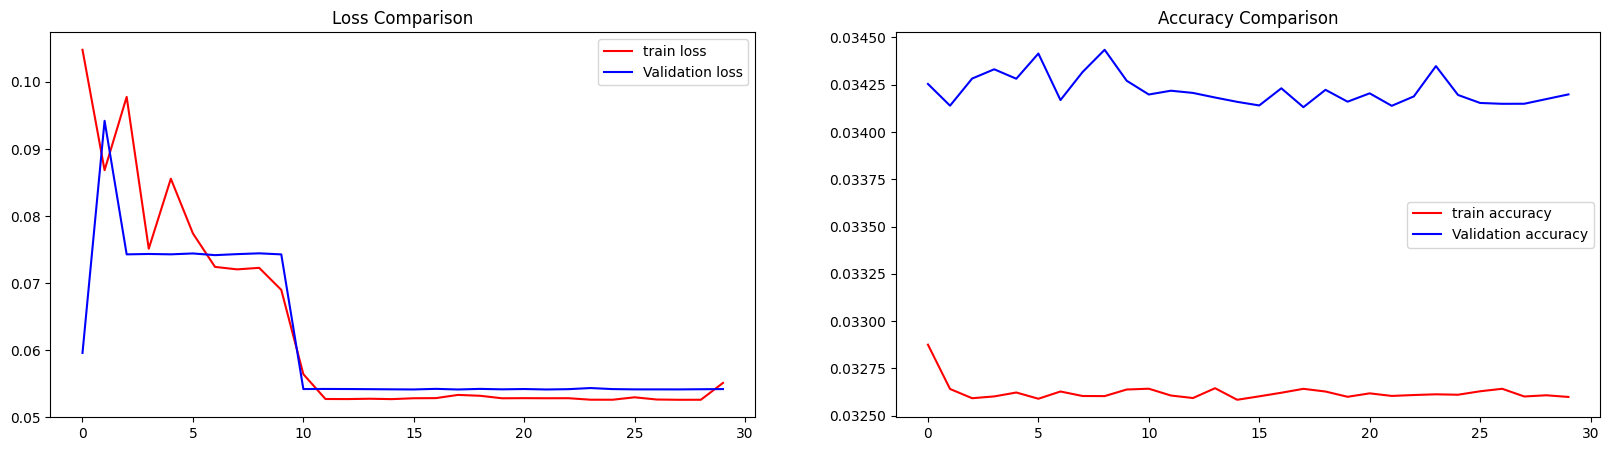

In [45]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'Validation loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["mae"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_mae"], color='b', label = 'Validation accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

In [ ]:
unet.evaluate(images_val, images_val_ab)

NameError: ignored

In [ ]:
pred = unet.predict(gray_valid[:,:,:,:])
pred.shape

In [ ]:
pred_rgb = tfio.experimental.color.lab_to_rgb(pred)
#valid_rgb = tfio.experimental.color.lab_to_rgb(valid)

In [ ]:
# Results of Validation Dataset
def VisualizeResults(index):
    valid_rgb = tfio.experimental.color.lab_to_rgb(valid[index,:,:,:])
    img = valid_rgb[index,:,:,0:1]
    img = img[np.newaxis, ...]
    pred_color = pred_rgb[index,:,:,:]
    pred_color = tf.argmax(pred_color[0], axis=-1)
    pred_color = pred_color[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(valid_rgb[index,:,:,:])
    arr[0].set_title('gray Image')
    arr[1].imshow(tfio.experimental.color.lab_to_rgb(valid[index,:,:,0]))
    arr[1].set_title('Actual Image ')
    arr[2].imshow(pred_color[:,:,0])
    arr[2].set_title('Predicted Image ')

In [ ]:
index = 1
VisualizeResults(index)

In [ ]:
def sample_batch(data, bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return idxs
def sample_images(data, gray, nrow, epoch):
    idx = sample_batch(gray, bsize=nrow)
    gray_batch = gray[idx]
    color_batch = data[idx]
    images = model.predict(gray_batch)
    return np.array([images, gray_batch, color_batch])